In [2]:
import pandas as pd
df = pd.read_csv(r"C:\Users\mk744\OneDrive - Poornima University\Desktop\Failure Risk Prediction\Notebook\data\employee.csv")
df.columns

Index(['First_Name', 'Last_Name', 'Age', 'Gender', 'City',
       'Highest_Qualification', 'Stream', 'Year_Of_Completion',
       'Are_you_currently_working', 'Company_Name', 'Your_Designation',
       'Employment_Type', 'Suitability_Label'],
      dtype='object')

In [3]:
features = [
    'First_Name', 'Last_Name', 'Age', 'Gender', 'City',
     'Highest_Qualification', 'Stream', 'Year_Of_Completion',
     'Are_you_currently_working', 'Company_Name', 'Your_Designation',
     'Employment_Type',
]

X = df[features]
y = df['Suitability_Label']


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

num_cols = ["Age"]
cat_cols = [
    'First_Name', 'Last_Name', 'Gender', 'City',
     'Highest_Qualification', 'Stream', 'Year_Of_Completion',
     'Are_you_currently_working', 'Company_Name', 'Your_Designation',
     'Employment_Type'
]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

pipeline = Pipeline([
    ("prep", preprocess),
    ("model", model)
])


In [7]:
param_grid = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [10, 20, 30, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

grid.fit(X_train, y_train)

print("Best Params:")
print(grid.best_params_)

y_pred = grid.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Params:
{'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 400}

Accuracy: 0.6052631578947368

Report:
                         precision    recall  f1-score   support

MidSenior_Not_Suitable       1.00      0.11      0.20         9
   Senior_Not_Suitable       0.52      0.81      0.63        16
              Suitable       0.75      0.69      0.72        13

              accuracy                           0.61        38
             macro avg       0.76      0.54      0.52        38
          weighted avg       0.71      0.61      0.56        38



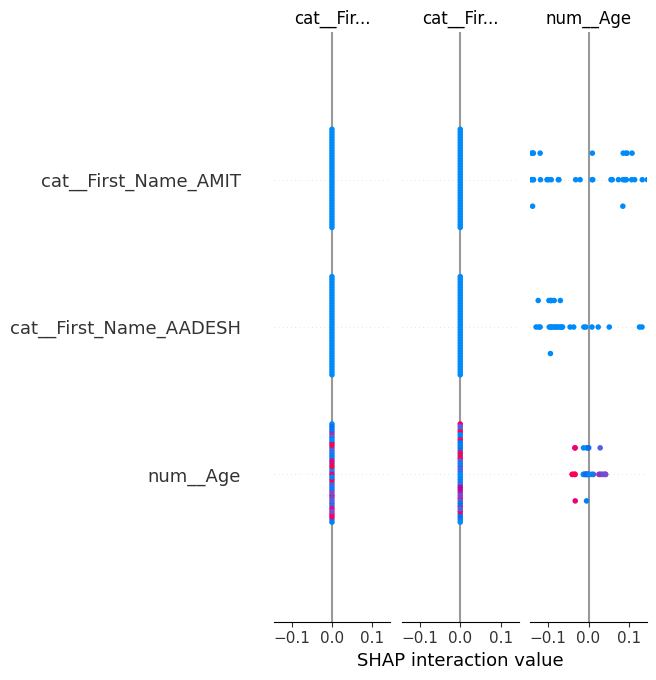

In [16]:
import shap
import numpy as np
from scipy import sparse

# Get the best pipeline and model
best_pipeline = grid.best_estimator_
rf_model = best_pipeline.named_steps["model"]

# Transform test data using the pipeline's preprocessing step
X_test_transformed = best_pipeline.named_steps["prep"].transform(X_test)

# Convert sparse → dense if needed
if sparse.issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

# Ensure float
X_test_transformed = X_test_transformed.astype(np.float64)

# Create SHAP explainer
explainer = shap.Explainer(rf_model, X_test_transformed)

# Get SHAP values
shap_values = explainer(X_test_transformed)

# Summary plot
shap.summary_plot(shap_values.values, X_test_transformed, feature_names=best_pipeline.named_steps["prep"].get_feature_names_out())


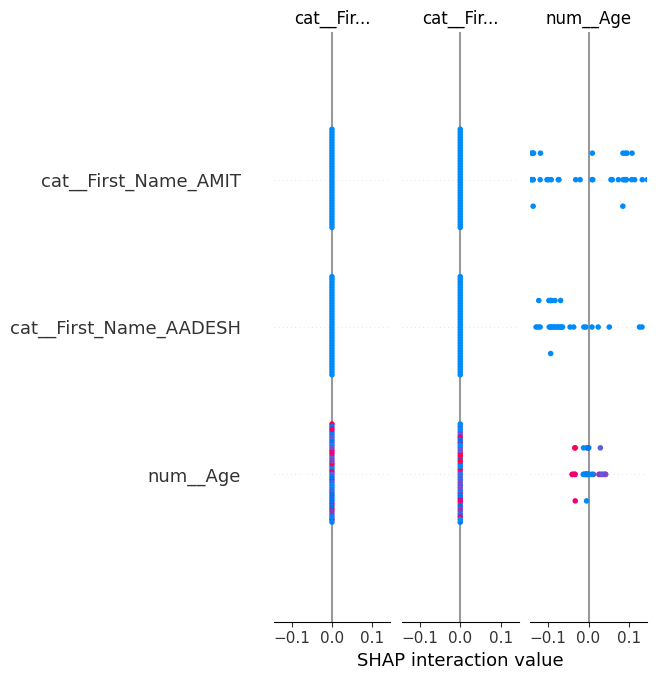

Accuracy on test data: 0.6053


In [17]:
import shap
import numpy as np
from scipy import sparse
from sklearn.metrics import accuracy_score

# --- Get best pipeline and model ---
best_pipeline = grid.best_estimator_
rf_model = best_pipeline.named_steps["model"]

# --- Transform test data ---
X_test_transformed = best_pipeline.named_steps["prep"].transform(X_test)

# Convert sparse → dense if needed
if sparse.issparse(X_test_transformed):
    X_test_transformed = X_test_transformed.toarray()

# Ensure float
X_test_transformed = X_test_transformed.astype(np.float64)

# --- SHAP Explainer ---
explainer = shap.Explainer(rf_model, X_test_transformed)
shap_values = explainer(X_test_transformed)

# --- SHAP Summary Plot ---
shap.summary_plot(
    shap_values.values, 
    X_test_transformed, 
    feature_names=best_pipeline.named_steps["prep"].get_feature_names_out()
)

# --- Accuracy Calculation ---
y_pred = best_pipeline.predict(X_test)  # use pipeline to include preprocessing
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.4f}")


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder, CountEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ---------------------------
# Load Data
# ---------------------------
# df = dataset   # <-- replace with your df

target_col = "Suitability_Label"

X = df.drop(columns=[target_col])
y = df[target_col]

# ---------------------------
# Column Groups
# ---------------------------
num_cols = ["Age"]

cat_target_enc_cols = [
    'Gender','City','Highest_Qualification','Stream',
    'Year_Of_Completion','Are_you_currently_working',
    'Your_Designation','Employment_Type'
]

identifier_cols = [
    "First_Name",
    "Last_Name",
    "Company_Name"
]

# ---------------------------
# Preprocessing
# ---------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),

        # Meaningful categories → Target Encoding
        ("target_enc", TargetEncoder(), cat_target_enc_cols),

        # Identifiers → Count Encoding
        ("count_enc", CountEncoder(), identifier_cols)
    ],
    remainder="drop"
)

# ---------------------------
# Model Pipeline with SMOTE
# ---------------------------
model = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced"
    ))
])

# ---------------------------
# Train Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# Train
# ---------------------------
model.fit(X_train, y_train)

# ---------------------------
# Evaluate
# ---------------------------
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.7666666666666667

Classification Report:

                        precision    recall  f1-score   support

MidSenior_Not_Suitable       1.00      0.43      0.60         7
   Senior_Not_Suitable       0.65      1.00      0.79        13
              Suitable       1.00      0.70      0.82        10

              accuracy                           0.77        30
             macro avg       0.88      0.71      0.74        30
          weighted avg       0.85      0.77      0.76        30



Cross Validation Accuracy Scores: [0.83333333 0.73333333 0.56666667 0.6        0.7       ]
Mean CV Accuracy: 0.6866666666666668

Accuracy: 0.7666666666666667

Classification Report:
                         precision    recall  f1-score   support

MidSenior_Not_Suitable       1.00      0.43      0.60         7
   Senior_Not_Suitable       0.65      1.00      0.79        13
              Suitable       1.00      0.70      0.82        10

              accuracy                           0.77        30
             macro avg       0.88      0.71      0.74        30
          weighted avg       0.85      0.77      0.76        30



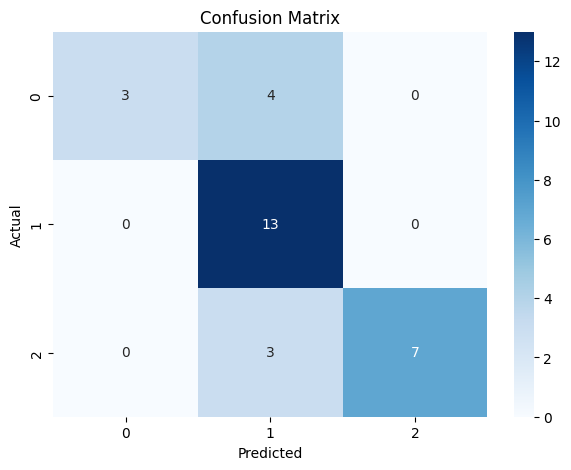


Calculating SHAP...


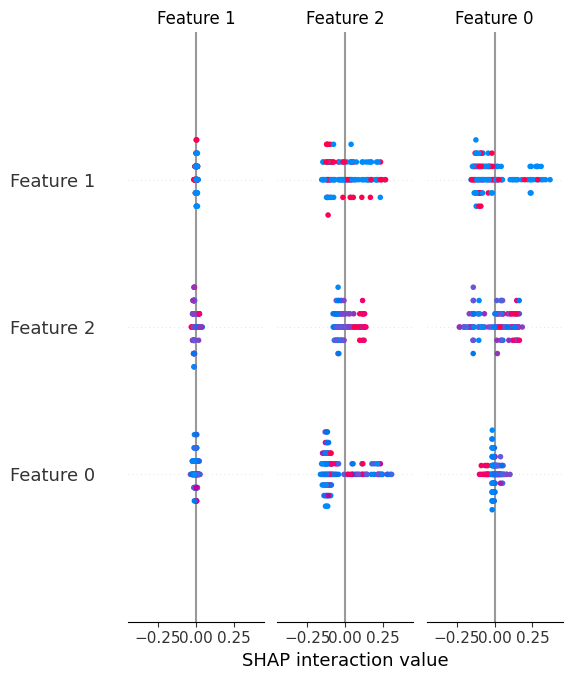

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder, CountEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# ---------------------------
# Load Data
# ---------------------------
# df = your_dataframe     # <-- replace with your DataFrame
target_col = "Suitability_Label"

X = df.drop(columns=[target_col])
y = df[target_col]

# ---------------------------
# Columns
# ---------------------------
num_cols = ["Age"]

cat_target_enc_cols = [
    'Gender','City','Highest_Qualification','Stream',
    'Year_Of_Completion','Are_you_currently_working',
    'Your_Designation','Employment_Type'
]

identifier_cols = [
    "First_Name",
    "Last_Name",
    "Company_Name"
]

# ---------------------------
# Preprocessing
# ---------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("target_enc", TargetEncoder(), cat_target_enc_cols),
        ("count_enc", CountEncoder(), identifier_cols)
    ],
    remainder="drop"
)

# ---------------------------
# Model Pipeline + SMOTE
# ---------------------------
model = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced"
    ))
])

# ---------------------------
# Train / Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# Cross Validation
# ---------------------------
cv_scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
print("Cross Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# ---------------------------
# Train Model
# ---------------------------
model.fit(X_train, y_train)

# ---------------------------
# Predictions
# ---------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------------------------
# Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------------------
# SHAP EXPLANATION
# ---------------------------
print("\nCalculating SHAP...")

# extract trained RF + transformed data
rf = model.named_steps["clf"]
X_train_transformed = model.named_steps["preprocess"].transform(X_train)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed)
